# Clustering Segments
---
Use feature table of segments to derive an alphabet for Pempheris Adspersa vocalisations.
Unsupervised clustering algorithm is fit to a chosen set of features and their corresponding cluster number is predicted. 

## Imports:

In [146]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import librosa
import datetime

from sklearn import cluster
from sklearn.metrics import silhouette_samples
from librosa import display

## Control Parameters:

In [147]:
sr = 16000 # sample rate

input_data_path = 'data/segmented/segment_features.csv'
segmented_data_dir = 'data/segmented/tank/'
results_data_dir = 'results/'

n_clusters = 5 # number of clusters to fit

# cluster sample image params
sample_size = 30
n_cols = 3
n_rows = 10

## Helper Functions:

In [434]:
'''
Description:
    Plots a signal waveform. 
Parameters:
    signal (numpy.ndarray): array of signal amplitudes
    sr (int): sample rate of waveform
Return:
    None
'''
def plot_signal(signal, sr=sr):
    no_samples = len(signal)
    plt.plot(np.linspace(0, no_samples/sr, no_samples), signal, color='navy')

## Load Feature Dataset:

In [367]:
df_main = pd.read_csv(input_data_path)
df_features = df_main.drop(columns=["file_id", "file_len_s"])
df_output = df_main[["file_id", "file_len_s"]].copy()

## Chosing featues to fit:

In [414]:
df_input = df_main[
    df_main.columns[df_main.columns.str.contains("mfcc_sum|mfcc_mean|lpcc_std|lpcc_max")]
]

df_input = df_input - df_input.mean() #removing DC components from mfcc and lpcc coefficients

df_input.head(2)

,mfcc_sum_0,mfcc_sum_1,mfcc_sum_2,mfcc_sum_3,mfcc_sum_4,mfcc_sum_5,mfcc_sum_6,mfcc_sum_7,mfcc_sum_8,mfcc_sum_9,...,lpcc_max_0,lpcc_max_1,lpcc_max_2,lpcc_max_3,lpcc_max_4,lpcc_max_5,lpcc_max_6,lpcc_max_7,lpcc_max_8,lpcc_max_9
0,63.493539,-44.428218,-22.144236,-12.925980,-4.941457,0.00744,3.699877,6.527771,7.262015,6.741608,...,-0.119719,0.035490,0.182351,0.020062,0.012364,-0.054088,-0.014456,-0.021748,-0.041931,0.033176
1,107.352439,-12.075053,-32.570064,-15.982147,-8.889280,0.00744,6.568144,8.084957,10.649557,1.617368,...,0.678071,0.236049,-0.200962,-0.056450,0.089415,0.221747,0.174188,0.066491,0.078800,0.066821


## Fitting Dataset and Predicting Clusters:

In [415]:
kmc = cluster.KMeans(n_clusters=n_clusters, init='k-means++')
clusters = kmc.fit_predict(df_input)

## Cluster Analysis:

In [416]:
# checking counts of samples assigned to each cluster
df_output["cluster"] = clusters
df_output["cluster"].value_counts()

2    11982
0     9659
1     8505
4     8087
3     5974
Name: cluster, dtype: int64

In [417]:
sample_silhouette_values = silhouette_samples(df_input, clusters)
df_output["silhouette_score"] = sample_silhouette_values

for n in range(n_clusters):
    print(f"Cluster {n} Silhouette Score:", df_output["silhouette_score"].loc[df_output["cluster"] == n].mean())
print("Average Silhouette Score:", df_output["silhouette_score"].mean())

Cluster 0 Silhouette Score: 0.29766603018171983
Cluster 1 Silhouette Score: 0.22732402308301733
Cluster 2 Silhouette Score: 0.3104226546574273
Cluster 3 Silhouette Score: 0.463622725126229
Cluster 4 Silhouette Score: 0.32250082573102334
Average Silhouette Score: 0.31456053537997297


## Saving primary clustered dataset and sample images from each cluster:

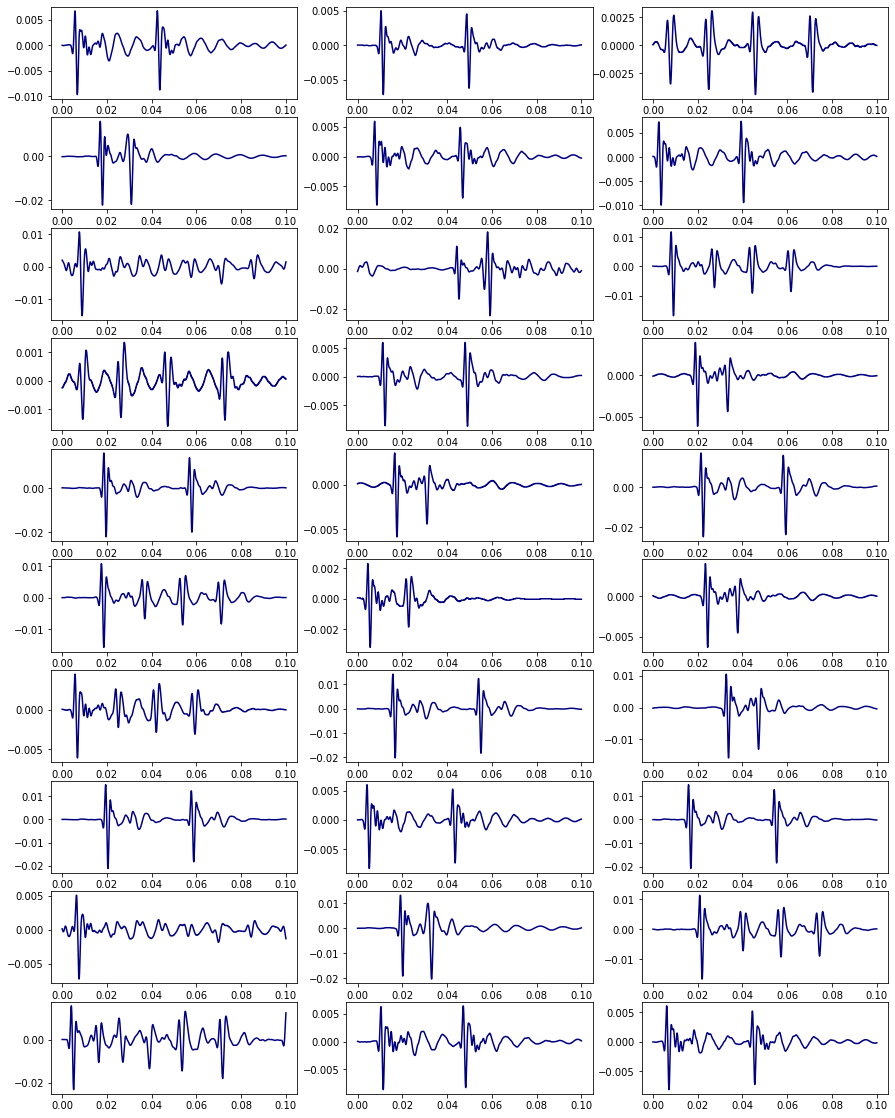

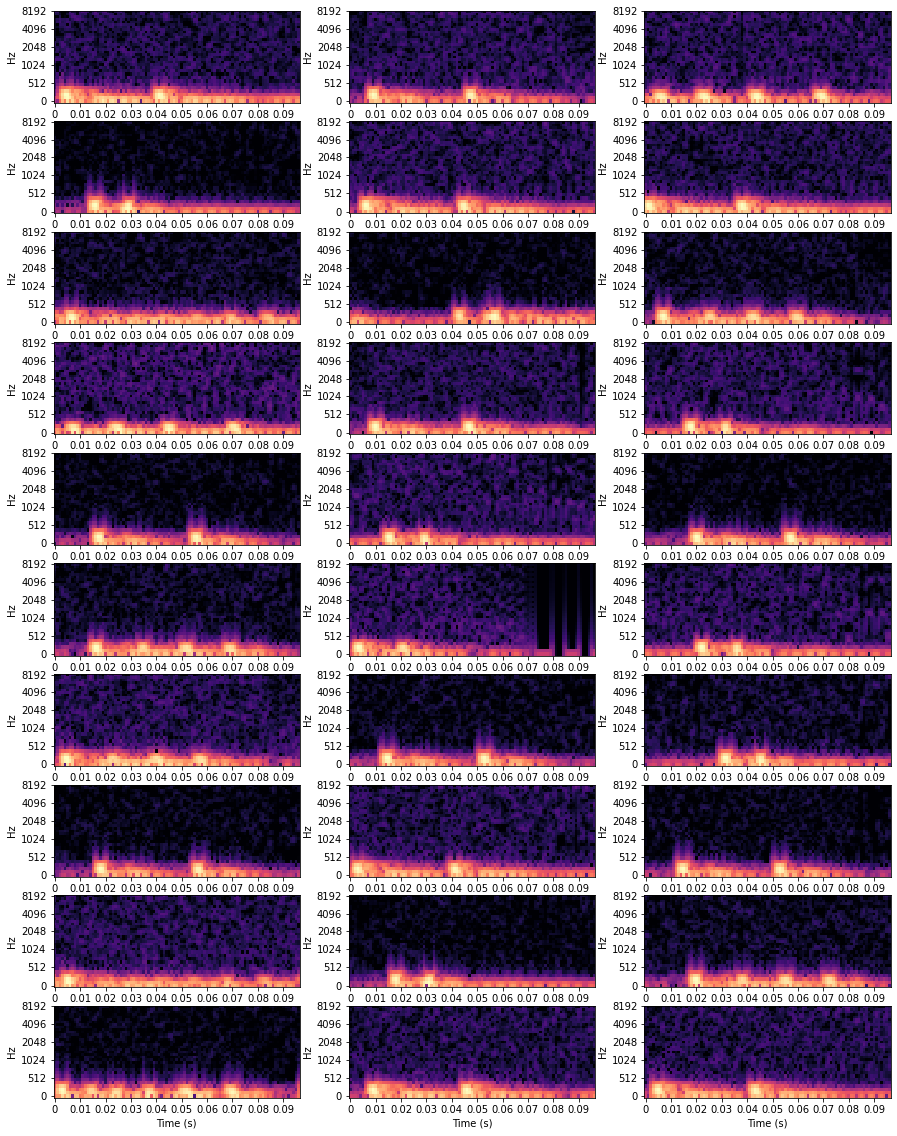

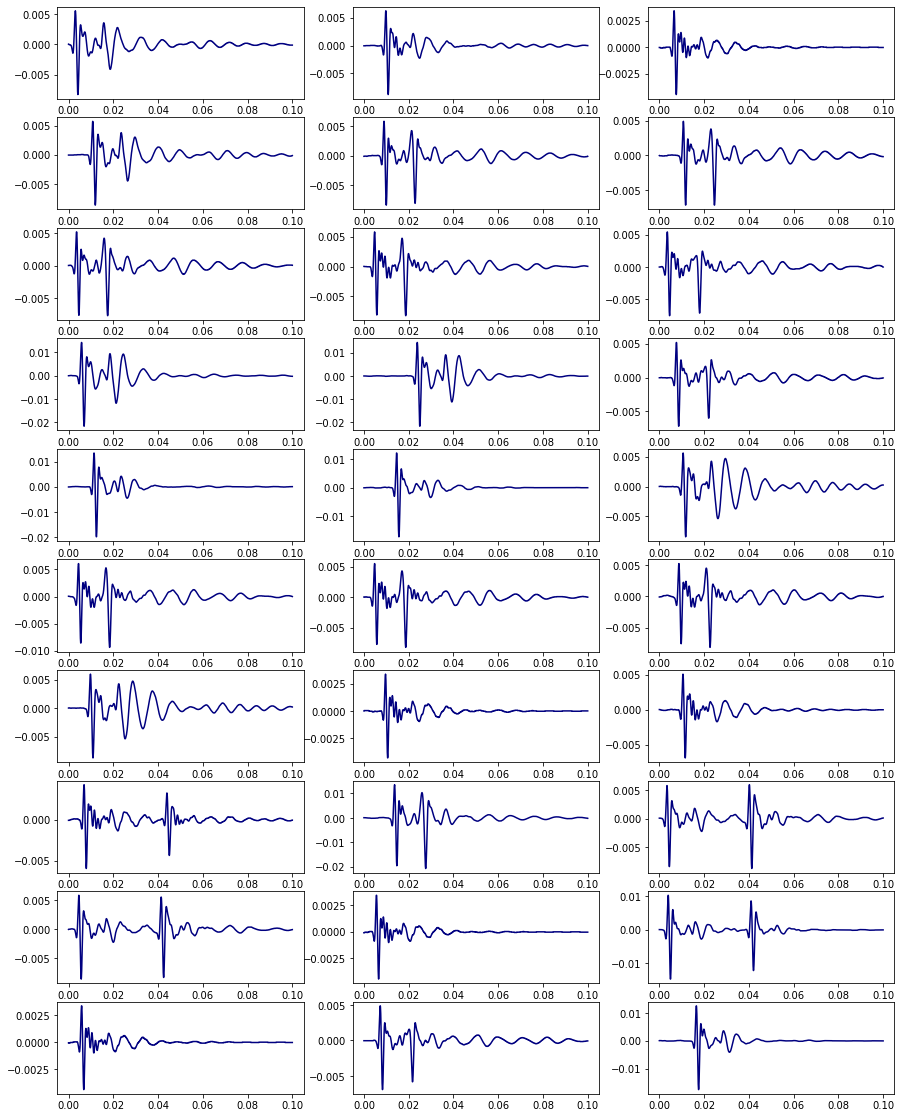

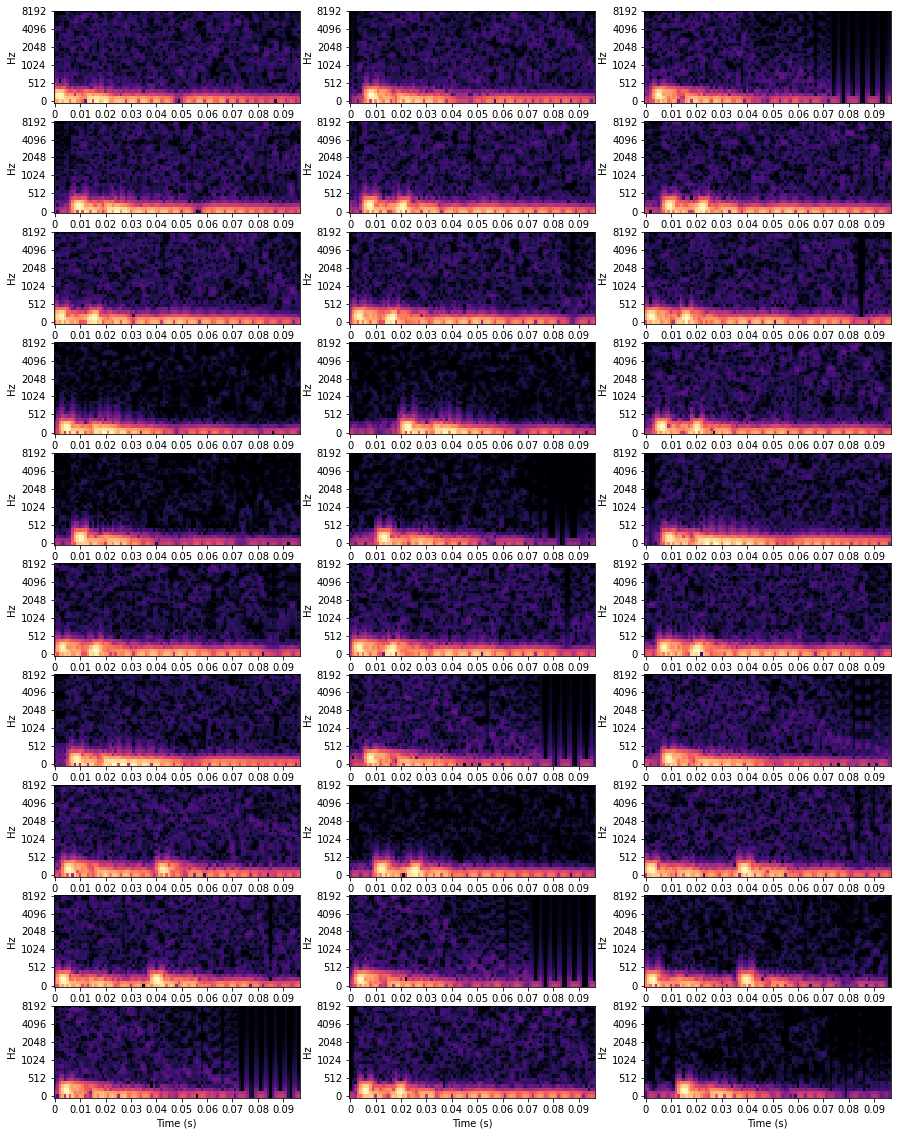

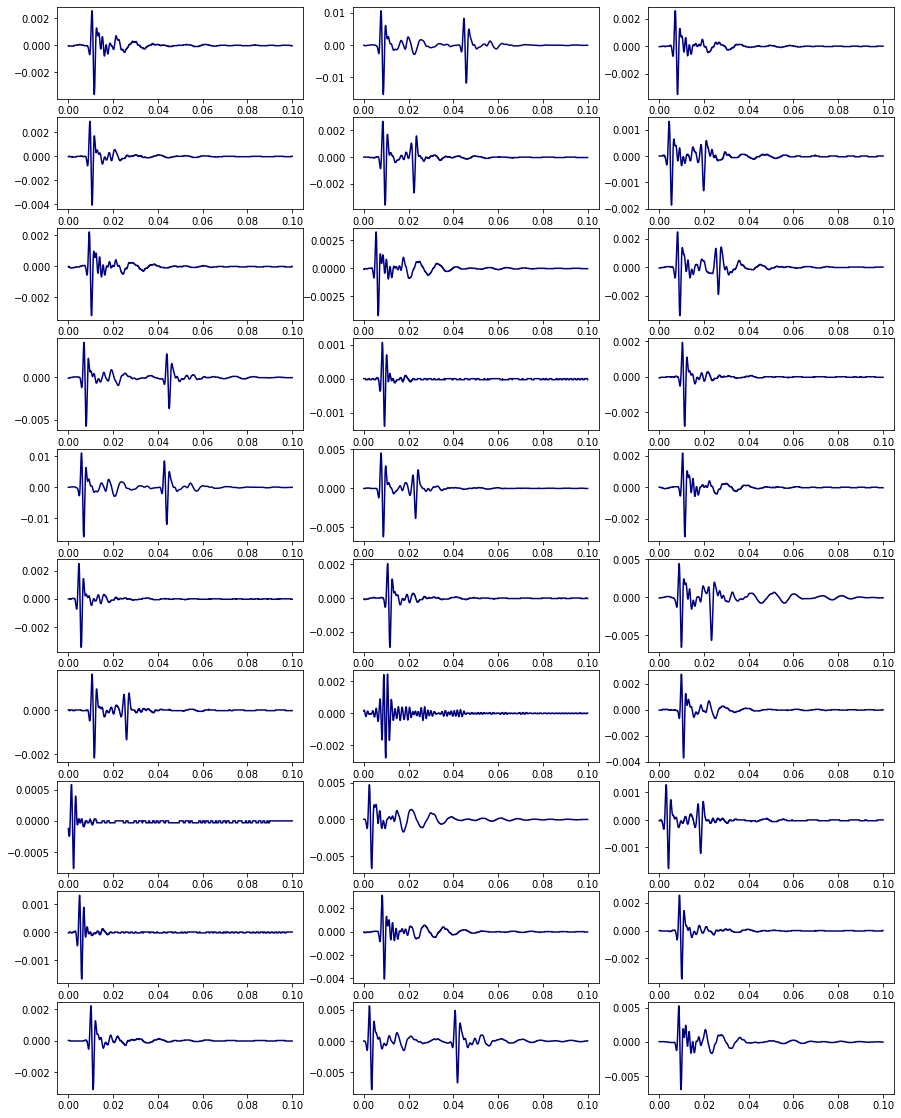

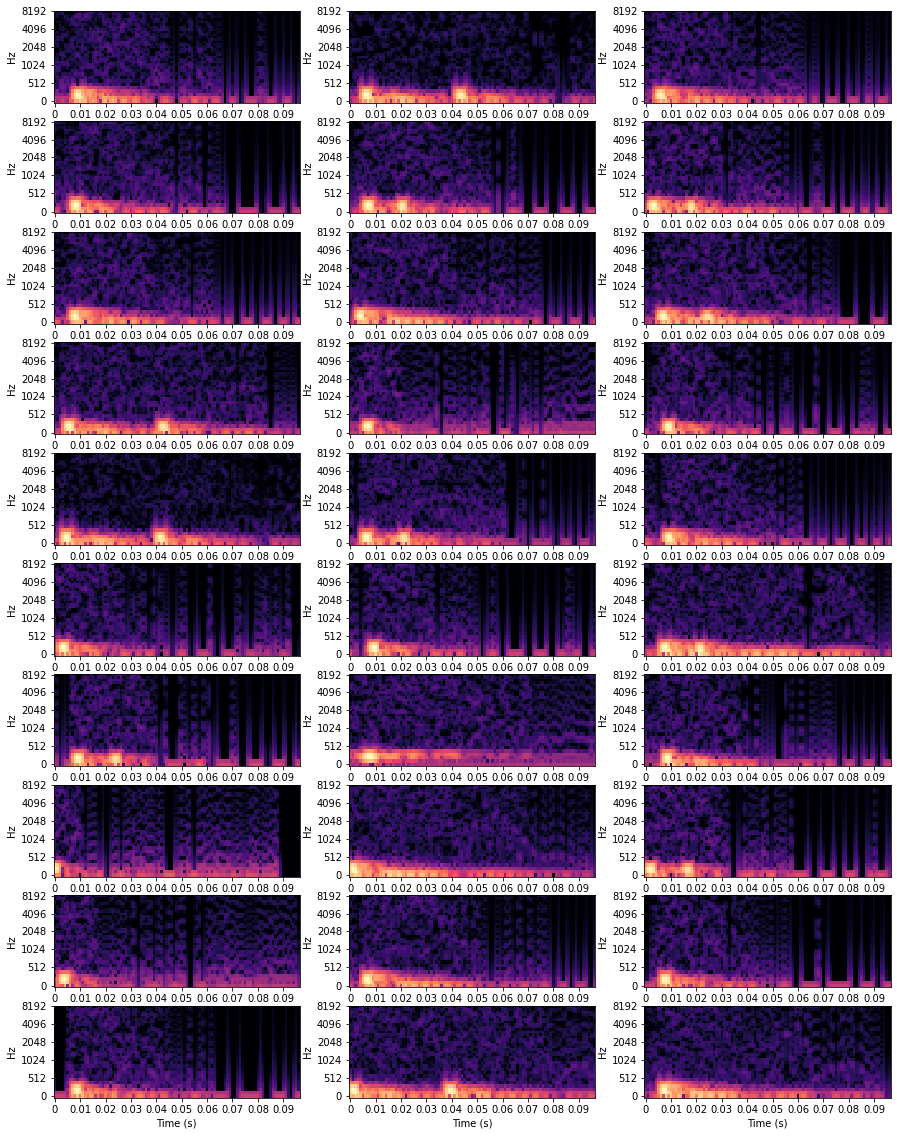

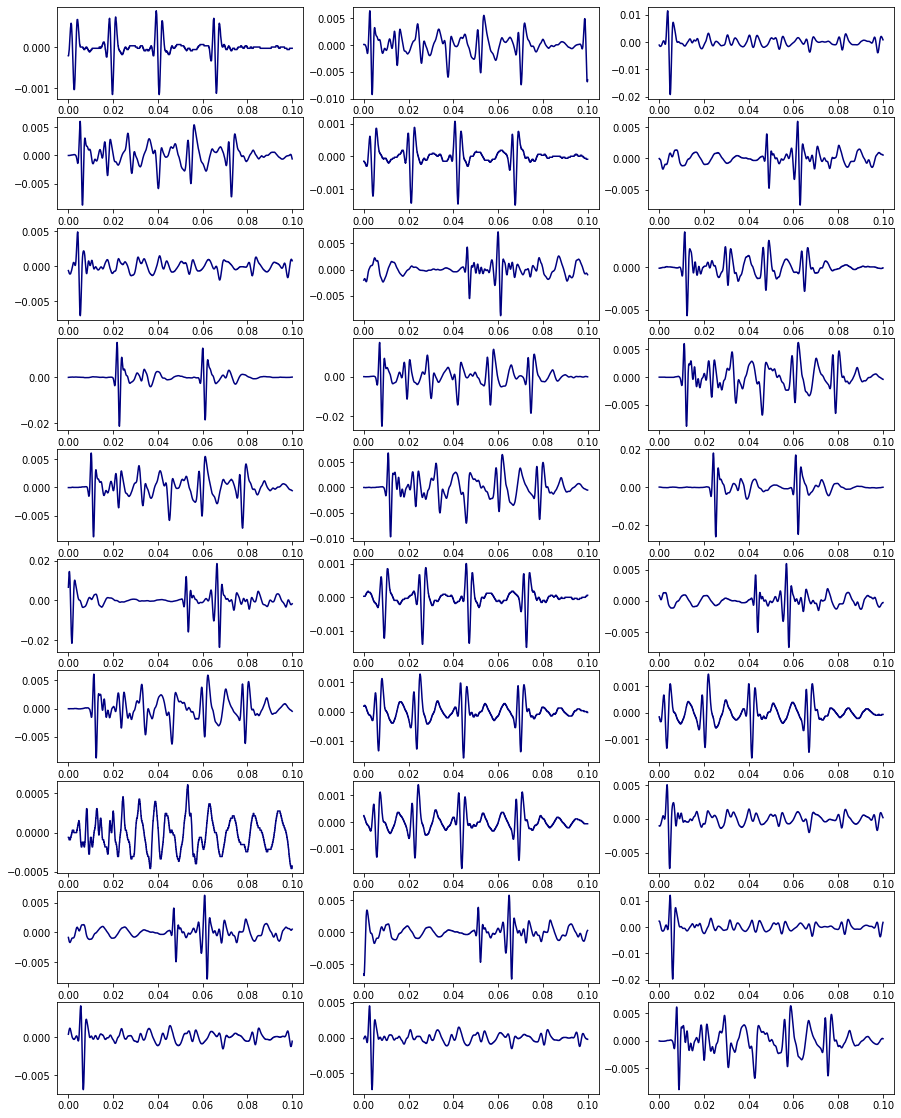

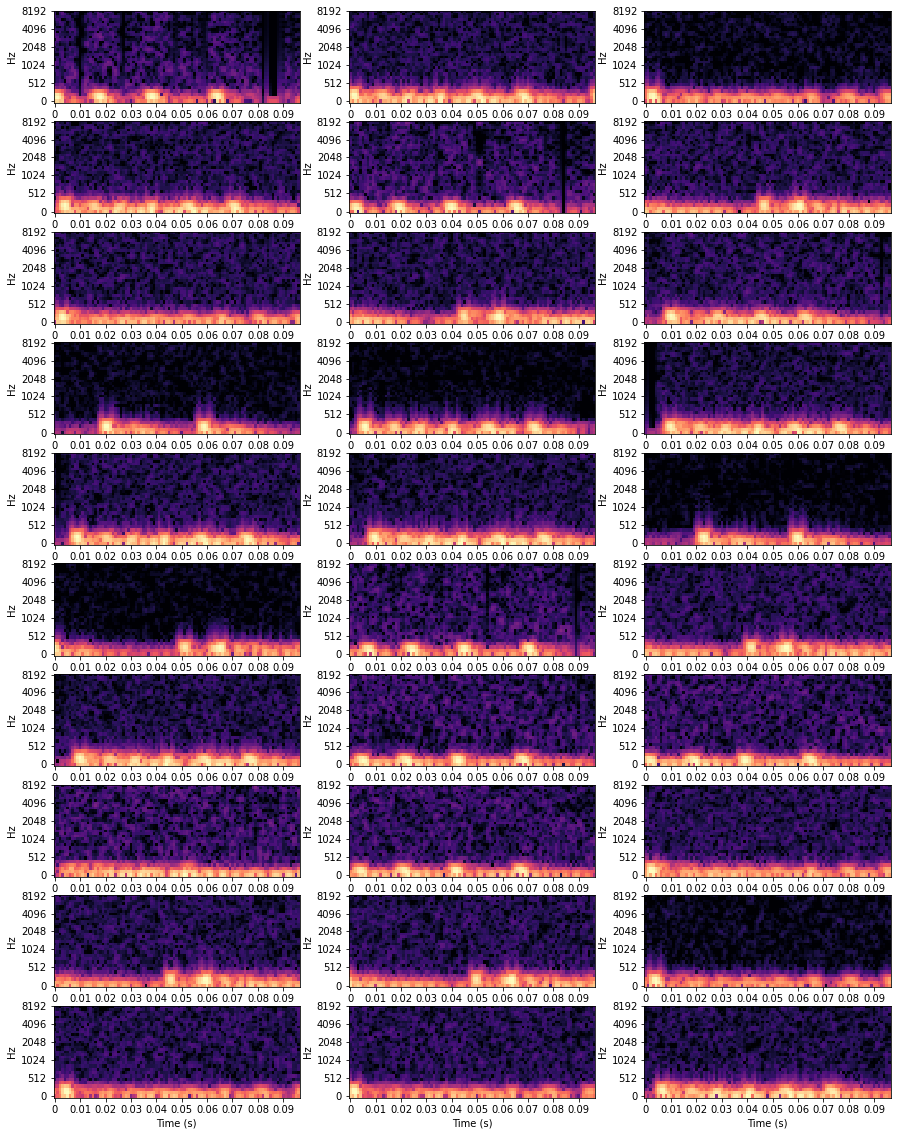

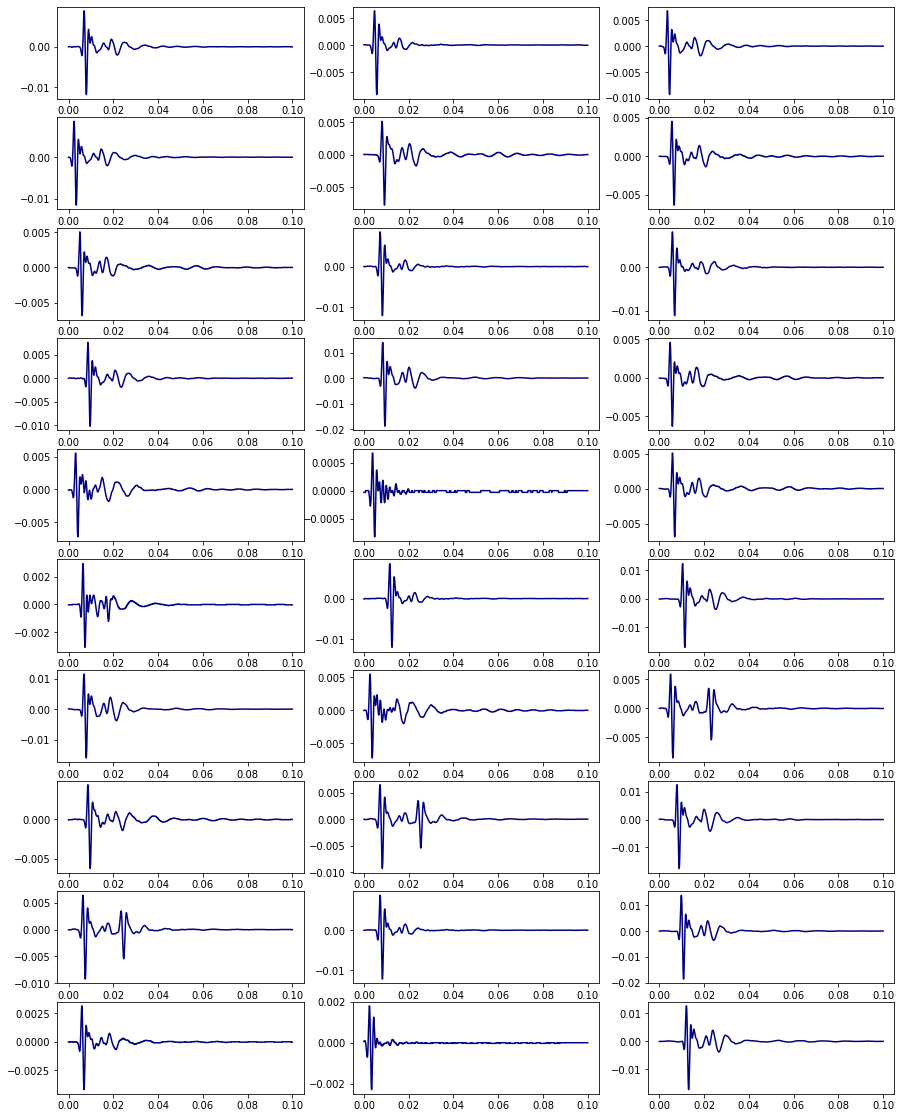

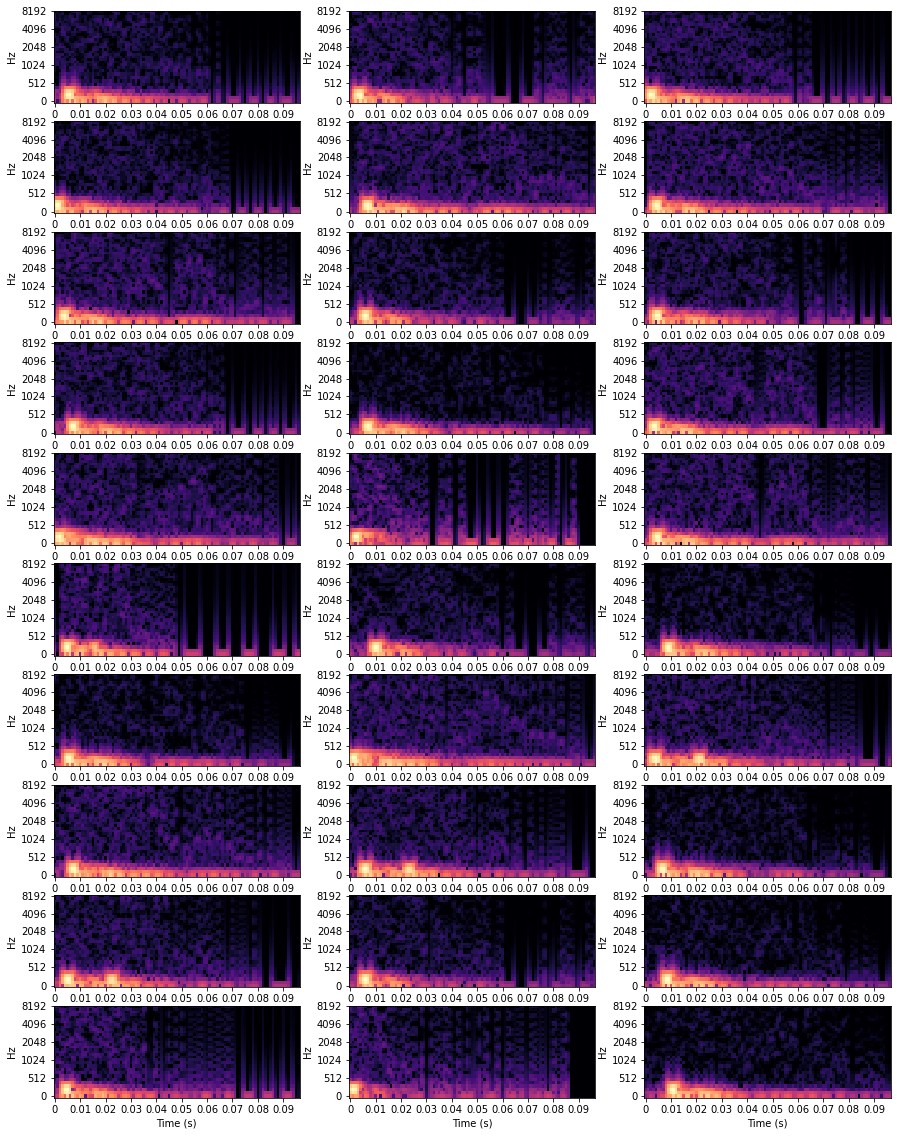

In [471]:
os.makedirs(results_data_dir, exist_ok=True)

for cluster_n in range(n_clusters):
    cluster_samples = [] 
    # getting a batch of samples from each cluster to inspect cluster quality
    for f in df_output.loc[df_output.cluster == cluster_n].sample(sample_size)["file_id"]:
        sample, _ = librosa.load(os.path.join(segmented_data_dir, f), sr=sr)
        cluster_samples.append(sample)

    plt.figure(figsize=(5*n_cols, 2*n_rows))
    for i in range(len(cluster_samples)):
        plt.subplot(n_rows, n_cols, i+1)
        plot_signal(cluster_samples[i])

    plt.savefig(os.path.join(results_data_dir, f"cluster_{cluster_n}.png"), 
            facecolor='white', bbox_inches='tight')

    plt.figure(figsize=(5*n_cols, 2*n_rows))
    for i in range(len(cluster_samples)):
        plt.subplot(n_rows, n_cols, i+1)
        dft = librosa.amplitude_to_db(np.abs(librosa.stft(cluster_samples[i], n_fft=64, hop_length=16, center=False)))
        display.specshow(dft, x_axis='s', y_axis='mel', cmap='magma', n_fft=64, hop_length=16, sr=sr)


    plt.savefig(os.path.join(results_data_dir, f"cluster_spectra_{cluster_n}.png"), 
            facecolor='white', bbox_inches='tight')

In [470]:
df_output = pd.concat([df_output, df_input], axis='columns')

df_output.to_csv(os.path.join(results_data_dir, 'model_out.csv'), index=False) # saving final dataset with predicted clusters.